In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel, get_mixture
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier, sample_and_plot

import scipy

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime
import time

2024-05-16 08:33:00.635485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 08:33:00.679159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 08:33:00.679193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 08:33:00.680143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 08:33:00.687316: I tensorflow/core/platform/cpu_feature_guar

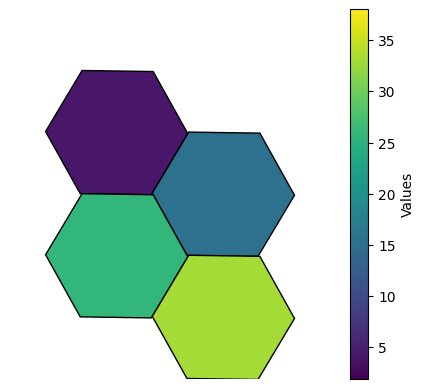

In [20]:
# Distribution Settings
scale = 1
means = [5, 15, 25, 35]

normal_4 = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]
sample_and_plot(normal_4)

S=4
# Historical data as features
H=2
# Total timepoints in data
T = 1000

learning_rate = 0.05

train_dataset, val_dataset, test_dataset, (train_X_THS, train_y_TS), (val_X_THS, val_y_TS), (test_X_THS, test_y_TS) = example_datasets(H, T, dist_S=normal_4, return_numpy=True)

In [3]:
class LocSpecificMixWeights(keras.layers.Layer):
    """Dumb layer that just returns mixture weights
    Constrained to unit norm
    """
    def __init__(self, num_locations, num_components=2, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(name='shared_mix_weights',
            shape=(num_locations, num_components ),
            initializer="uniform",
            trainable=True,
        )
        
        self.softmax = keras.layers.Softmax(axis=1)

    def call(self, inputs):
        return self.softmax(self.w)

def build_mixture_normal(parameter_model, input_shape, scale=1, num_components=4, seed=360):
    num_features, num_locations = input_shape
    member_models = []
    for c in range(num_components):
        member_models.append(parameter_model(input_shape, seed=seed+1000*c))

    # Define layers
    inputs = keras.Input(shape=input_shape, name='mix_input')
    reshape_layer = keras.layers.Reshape(name='mix_reshape', target_shape=(-1,1))
    concat_layer = keras.layers.Concatenate(name='mix_concat',axis=-1)

    mixture_weight_layer = LocSpecificMixWeights(num_locations, name='mixture_weights', num_components=num_components)

    reshaped = [reshape_layer(member(inputs)) for member in member_models]
    concatted = concat_layer(reshaped)
    
    mixture_weights = mixture_weight_layer(inputs)

    mixture_distribution_layer = tfp.layers.DistributionLambda(lambda params: 
        tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=params[0]),
                                            components_distribution = tfp.distributions.Normal(loc=params[1], scale=scale, validate_args=True)))
    
    outputs = mixture_distribution_layer([mixture_weights, concatted])

    model = keras.Model(name='mixture_model', inputs=inputs, outputs=[outputs])

    return model 



In [21]:
model = build_mixture_normal(location_specific_linear, (H, S),scale=scale, num_components=4)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [5]:
# Set linear weights to 0
for index in [0, 2, 4, 6]:
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tf.zeros(variable.shape))

Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)


In [6]:
# set biases to true value
for index, bias in zip([1, 3, 5, 7], [5.0, 15.0, 25.0, 35.0]):
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([bias]))

Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)


In [7]:
index = -1
variable = model.trainable_variables[index]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')

weights = tf.eye(4)

variable.assign(tf.math.log(weights+1e-13))

Name: shared_mix_weights:0
Shape: (4, 4)


<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[  0.      , -29.933605, -29.933605, -29.933605],
       [-29.933605,   0.      , -29.933605, -29.933605],
       [-29.933605, -29.933605,   0.      , -29.933605],
       [-29.933605, -29.933605, -29.933605,   0.      ]], dtype=float32)>

In [8]:
mixture_model = model(train_X_THS)

In [22]:
num_score_func_samples=5

In [10]:
sample_y_MBS = mixture_model.sample(num_score_func_samples)
print(f'Sample y shape {sample_y_MBS.shape}')


sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

# no cross-ratio decision here
sample_decisions_MBS = tf.identity(sample_y_MBS)
expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
print(f'Expected decisions shape {expected_decisions_BS.shape}')
loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
loss = tf.reduce_mean(loss_B)

Sample y shape (50, 600, 4)
Expected decisions shape (600, 4)


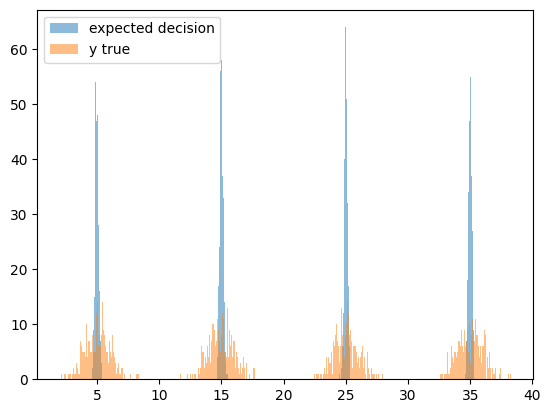

In [11]:
plt.hist(tf.reshape(expected_decisions_BS, [-1]).numpy(),alpha=0.5, bins=1000, label='expected decision')
plt.hist(tf.reshape(train_y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

In [24]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
_callbacks = [tensorboard_callback]
callbacks = tf.keras.callbacks.CallbackList(
    _callbacks, add_history=True, model=model)


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     mixture_distribution_layer = tfp.layers.DistributionLambda(lambda params: 
        tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=params[0]),
                                            components_distribution = tfp.distributions.Normal(loc=params[1], scale=scale, validate_args=True)))

  config_arr = [serialize_keras_object(x) for x in obj]


In [25]:
param_value = 23.0
print(param_value)
variable = model.trainable_variables[5]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')
variable.assign(tfp.math.softplus_inverse([param_value]))

23.0
Name: linear_convolution/bias:0
Shape: (1,)


<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([23.], dtype=float32)>

In [28]:
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [29]:
logs = {}
callbacks.on_train_begin(logs=logs)
tf.summary.trace_on(graph=True, profiler=True)
for epoch in range(1):
    callbacks.on_epoch_begin(epoch, logs=logs)
    for batch, (x_batch, y_batch) in enumerate(train_dataset):
        callbacks.on_batch_begin(batch, logs=logs)
        callbacks.on_train_batch_begin(batch, logs=logs)
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
            mixture_model = model(train_X_THS, training=True)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

            # no cross-ratio decision here
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))
        callbacks.on_test_batch_end(batch, logs=logs)
        callbacks.on_batch_end(batch, logs=logs)
    callbacks.on_epoch_end(epoch, logs=logs)
callbacks.on_train_end(logs=logs)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


2024-05-16 08:57:47.641839: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-05-16 08:57:47.641869: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


2024-05-16 08:57:55.942434: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-05-16 08:57:55.956820: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [12]:
gradient_magnitudes = []
master_magnitudes = []
param_vals = []
losses = []
mean_log_probs = []
for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(1):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            mixture_model = model(train_X_THS)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

            # no cross-ratio decision here
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        gradient_magnitudes.append(overall_gradient[5])
        master_magnitudes.append(master_gradient[5])
        losses.append(loss)
        mean_log_probs.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Name: linear_convolution/bias:0
Shape: (1,)
